# Handout #5

In [1]:
# Imports
import os
import json
import numpy as np
import pandas as pd
import pickle

from pathlib import Path

---
Page `66 - 67` - Power iteration

In [2]:
# Page 66
x0 = np.matrix([1/7] * 7)
P = np.matrix([
        [1/7, 1/7, 1/7, 1/7, 1/7, 1/7, 1/7],
        [25/56, 3/140, 25/56, 3/140, 3/140, 3/140, 3/140],
        [3/140, 3/140, 3/140, 3/140, 61/70, 3/140, 3/140],
        [3/140, 3/140, 25/56, 3/140, 3/140, 3/140, 25/56],
        [25/56, 3/140, 3/140, 3/140, 3/140, 25 /56, 3/140],
        [3/140, 3/140, 61/70, 3/140, 3/140, 3/140, 3/140],
        [3/140, 3/140, 25/56, 3/140, 3/140, 25/56, 3/140],
    ])

prev_Px = x0
Px = x0*P
i=0
while(any(abs(np.asarray(prev_Px).flatten()-np.asarray(Px).flatten()) > 1e-8)):
    i+=1
    prev_Px = Px
    Px = Px * P

print('Converged in {0} iterations: {1}'.format(i, np.asarray(Px).flatten()))

Converged in 39 iterations: [0.16911688 0.04196419 0.25324048 0.04196419 0.2572186  0.17669667
 0.05979897]


---
Page `68 - 70` - The PageRank score

In [3]:
# Page 68,69
# PageRank class definition
class Pr:
    def __init__(self, alpha, max_depth=2):  # Add max_depth argument
        self.crawled_folder = Path(os.path.abspath('')).parent / 'crawled/'
        self.alpha = alpha
        self.max_depth = max_depth  # Store max depth

    def url_extractor(self, current_depth=0):
        # If the maximum depth has been reached, stop crawling
        if current_depth >= self.max_depth:
            return {}, set()

        url_maps = {}
        all_urls = set([])

        for file in os.listdir(self.crawled_folder):
            if file.endswith(".txt"):
                j = json.load(open(os.path.join(self.crawled_folder, file)))
                all_urls.add(j['url'])
                for s in j['url_lists']:
                    all_urls.add(s)
                url_maps[j['url']] = list(set(j['url_lists']))

        # Proceed to the next level (increase depth) and update the maps
        if current_depth < self.max_depth - 1:  # Only recurse further if we haven't reached max depth
            nested_url_maps, nested_all_urls = self.url_extractor(current_depth + 1)
            url_maps.update(nested_url_maps)
            all_urls.update(nested_all_urls)

        all_urls = list(all_urls)
        return url_maps, all_urls

    def pr_calc(self):
        url_maps, all_urls = self.url_extractor()  # No need to pass depth here, it’s managed by default
        url_matrix = pd.DataFrame(columns=all_urls, index=all_urls)

        for url in url_maps:
            if len(url_maps[url]) > 0 and len(all_urls) > 0:
                url_matrix.loc[url] = (1 - self.alpha) * (1 / len(all_urls))
                url_matrix.loc[url, url_maps[url]] = url_matrix.loc[url, url_maps[url]] + (self.alpha * (1 / len(url_maps[url])))

        url_matrix.loc[url_matrix.isnull().all(axis=1), :] = (1 / len(all_urls))

        x0 = np.matrix([1 / len(all_urls)] * len(all_urls))
        P = np.asmatrix(url_matrix.values)

        prev_Px = x0
        Px = x0 * P
        i = 0
        while (any(abs(np.asarray(prev_Px).flatten() - np.asarray(Px).flatten()) > 1e-8)):
            i += 1
            prev_Px = Px
            Px = Px * P

        print('Converged in {0} iterations: {1}'.format(i, np.around(np.asarray(Px).flatten().astype(float), 5)))

        self.pr_result = pd.DataFrame(Px, columns=url_matrix.index, index=['score']).T


In [4]:
s = Pr(alpha=0.85, max_depth=2)  # Setting max_depth to 2
s.pr_calc()

Converged in 13 iterations: [3.e-05 3.e-05 3.e-05 ... 3.e-05 3.e-05 3.e-05]


In [5]:
# Page 70
print(s.pr_result.sort_values(by='score', ascending=False))

                                                       score
https://cmu.ac.th/en/                               0.000915
https://cmu.ac.th/                                  0.000635
https://voc.cmu.ac.th/Choose.aspx                    0.00059
https://cmu.ac.th/en/#top                            0.00055
https://council.cmu.ac.th/th/members-of-cmu-cou...  0.000543
...                                                      ...
https://cmu.ac.th/th/article/d4ad7bb2-ff64-4d07...  0.000028
https://cmu.ac.th/th/article/12962344-24e2-4563...  0.000028
https://cmu.ac.th/th/article/c995e042-b6ed-4d61...  0.000028
https://cmu.ac.th/en/Procurement/ea984a8b-a44e-...  0.000028
https://cmu.ac.th/en/Procurement/52a1c968-f575-...  0.000028

[33290 rows x 1 columns]


`pr_calc result:` (unfold to see image)

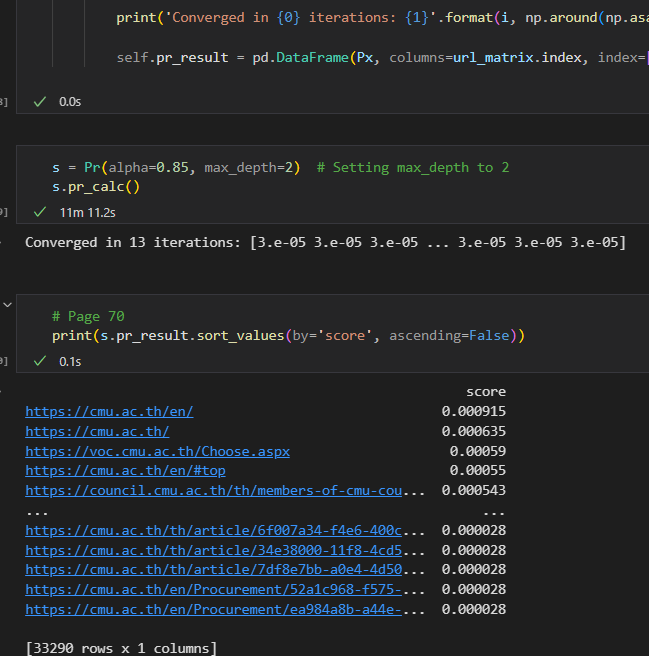

---
Page `71 - 75` - Integrating the PageRank score with Elasticsearch


In [ ]:
# Page 71
import os
import json
import pickle
from pathlib import Path
from elasticsearch import Elasticsearch

class IndexerWithPR:

    def __init__(self):
        self.crawled_folder = Path(os.path.abspath('')).parent / 'crawled/'
        with open(self.crawled_folder / 'url_list.pickle', 'rb') as f:
            self.file_mapper = pickle.load(f)
        
        self.es_client = Elasticsearch("https://localhost:9200", basic_auth=("elastic", "_Z9BSk2zcMuFD=-1LlAX"), ca_certs="~/http_ca.crt")
        self.pr = Pr(alpha=0.85)

    def run_indexer(self):
        """ Creates and populates the 'simple' index with BM25 and PageRank. """
        self.pr.pr_calc()
        self.es_client.options(ignore_status=[400, 404]).indices.delete(index='simple')
        self.es_client.options(ignore_status=[400]).indices.create(index='simple')

        for file in os.listdir(self.crawled_folder):
            if file.endswith(".txt"):
                j = json.load(open(os.path.join(self.crawled_folder, file)))
                j['id'] = j['url']
                j['pagerank'] = self.pr.pr_result.loc[j['id']].score
                self.es_client.index(index='simple', body=j)

    # Page 76 (additional)
    def run_manual_indexer(self):
        """ Creates and populates the 'manual' index with a custom BM25 similarity. """
        self.pr.pr_calc()
        self.es_client.options(ignore_status=[400, 404]).indices.delete(index='manual')
        
        index_body = {
            "settings": {
                "similarity": {
                    "custom_bm25": {
                        "type": "BM25",
                        "b": 0.75,
                        "k1": 1.2
                    }
                }
            },
            "mappings": {
                "properties": {
                    "text": {
                        "type": "text",
                        "similarity": "custom_bm25"
                    },
                    "pagerank": {
                        "type": "double"
                    }
                }
            }
        }
        
        self.es_client.options(ignore_status=400).indices.create(index='manual', body=index_body)
        
        for file in os.listdir(self.crawled_folder):
            if file.endswith(".txt"):
                j = json.load(open(os.path.join(self.crawled_folder, file)))
                j['id'] = j['url']
                j['pagerank'] = self.pr.pr_result.loc[j['id']].score
                self.es_client.index(index='manual', body=j)

    # Assignment 5
    def run_tfidf_indexer(self):
        """ Creates and populates the 'tfidf_index' with TF-IDF similarity and PageRank values. """
        self.pr.pr_calc()
        self.es_client.options(ignore_status=[400, 404]).indices.delete(index='tfidf_index')

        index_body = {
            "settings": {
                "index": {
                    "similarity": {
                        "default": {
                            "type": "classic"  # Enables TF-IDF similarity
                        }
                    }
                }
            },
            "mappings": {
                "properties": {
                    "text": {
                        "type": "text"  # Uses default TF-IDF similarity
                    },
                    "title": {
                        "type": "text"
                    },
                    "url": {
                        "type": "keyword"
                    },
                    "pagerank": {
                        "type": "double"
                    }
                }
            }
        }

        self.es_client.options(ignore_status=400).indices.create(index='tfidf_index', body=index_body)

        for file in os.listdir(self.crawled_folder):
            if file.endswith(".txt"):
                j = json.load(open(os.path.join(self.crawled_folder, file)))
                j['id'] = j['url']
                j['pagerank'] = self.pr.pr_result.loc[j['id']].score
                self.es_client.index(index='tfidf_index', body=j)


In [7]:
# Run indexer
indexer = IndexerWithPR()

In [8]:
indexer.run_indexer()

Converged in 13 iterations: [3.e-05 3.e-05 3.e-05 ... 3.e-05 3.e-05 3.e-05]


ConnectionError: Connection error caused by: ConnectionError(Connection error caused by: NewConnectionError(<elastic_transport._node._urllib3_chain_certs.HTTPSConnection object at 0x0000013AB775AAE0>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it))

In [ ]:
query = {'bool': {'must': [{'match': {'text': 'camt'}}]}}
results = indexer.es_client.search(index='simple', query=query)
print("Got %d Hits:" % results['hits']['total']['value'])
for hit in results['hits']['hits']:
    print("The title is '{0} ({1})'.".format(hit["_source"]['title'], hit["_source"]['url']))

Got 76 Hits:
The title is 'วิทยาลัยศิลปะ สื่อ และเทคโนโลยี - มหาวิทยาลัยเชียงใหม่ (https://cmu.ac.th/th/faculty/the_college_of_arts_media_and_technology/aboutus)'.
The title is 'วิทยาลัยศิลปะ สื่อ และเทคโนโลยี - มหาวิทยาลัยเชียงใหม่ (https://cmu.ac.th/en/faculty/the_college_of_arts_media_and_technology/aboutus)'.
The title is 'News : Mass Comm and CAMT join forces to offer the first digital film programme in the Northern region - Chiang Mai University (https://cmu.ac.th/en/article/9b6860b6-4d17-4ab9-9ab3-9c5f3ee642e9)'.
The title is 'News : CAMT Signs MoU on Academic and Research Development with University of Bremen, Germany - Chiang Mai University (https://cmu.ac.th/en/article/a0db2c1c-60bd-4e0f-a73c-c0390f100577)'.
The title is 'News : CAMT Strengthens Collaboration with Imperial College London Fostering Research and Expanding Partnerships - Chiang Mai University (https://cmu.ac.th/en/article/ed6876fa-0e96-41dd-b409-eb1f7613cae2)'.
The title is 'วิทยาลัยศิลปะ สื่อ และเทคโนโลยี - มหา

---
Running `Manual Indexer`

In [ ]:
indexer.run_manual_indexer()

Converged in 13 iterations: [3.e-05 3.e-05 3.e-05 ... 3.e-05 3.e-05 3.e-05]


In [ ]:
query = {'bool': {'must': [{'match': {'text': 'camt'}}]}}
results = indexer.es_client.search(index='manual', query=query)
print("Got %d Hits:" % results['hits']['total']['value'])
for hit in results['hits']['hits']:
    print("The title is '{0} ({1})'.".format(hit["_source"]['title'], hit["_source"]['url']))

Got 76 Hits:
The title is 'วิทยาลัยศิลปะ สื่อ และเทคโนโลยี - มหาวิทยาลัยเชียงใหม่ (https://cmu.ac.th/th/faculty/the_college_of_arts_media_and_technology/aboutus)'.
The title is 'วิทยาลัยศิลปะ สื่อ และเทคโนโลยี - มหาวิทยาลัยเชียงใหม่ (https://cmu.ac.th/en/faculty/the_college_of_arts_media_and_technology/aboutus)'.
The title is 'News : Mass Comm and CAMT join forces to offer the first digital film programme in the Northern region - Chiang Mai University (https://cmu.ac.th/en/article/9b6860b6-4d17-4ab9-9ab3-9c5f3ee642e9)'.
The title is 'News : CAMT Signs MoU on Academic and Research Development with University of Bremen, Germany - Chiang Mai University (https://cmu.ac.th/en/article/a0db2c1c-60bd-4e0f-a73c-c0390f100577)'.
The title is 'News : CAMT Strengthens Collaboration with Imperial College London Fostering Research and Expanding Partnerships - Chiang Mai University (https://cmu.ac.th/en/article/ed6876fa-0e96-41dd-b409-eb1f7613cae2)'.
The title is 'วิทยาลัยศิลปะ สื่อ และเทคโนโลยี - มหา

---
Running `TF-IDF Indexer` (Assignment 5)

In [ ]:
indexer.run_tfidf_indexer()

In [ ]:
query = {'bool': {'must': [{'match': {'text': 'camt'}}]}}
results = indexer.es_client.search(index='tfidf_index', query=query)
print("Got %d Hits:" % results['hits']['total']['value'])
for hit in results['hits']['hits']:
    print("The title is '{0} ({1})'.".format(hit["_source"]['title'], hit["_source"]['url']))

`Page 76` - Extended exercise
- Integrate PageRank to your manual_index with route /search_manual_pr
- Multiply PageRank score with the original BM25
- Check with Postman or a web browser

In [ ]:
# Import BM25
import re
import numpy as np
from scipy import sparse
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer


class BM25(object):
    def __init__(self, vectorizer, b=0.75, k1=1.6):
        self.vectorizer = vectorizer
        self.b = b
        self.k1 = k1

    def fit(self, X):
        """ Fit IDF to documents X """
        self.vectorizer.fit(X)
        self.y = super(TfidfVectorizer, self.vectorizer).transform(X)
        self.avdl = self.y.sum(1).mean()

    def transform(self, q):
        """ Calculate BM25 between query q and documents X """
        b, k1, avdl = self.b, self.k1, self.avdl

        # apply CountVectorizer
        len_y = self.y.sum(1).A1
        q, = super(TfidfVectorizer, self.vectorizer).transform([q])
        assert sparse.isspmatrix_csr(q)

        # convert to csc for better column slicing
        y = self.y.tocsc()[:, q.indices]
        denom = y + (k1 * (1 - b + b * len_y / avdl))[:, None]
        idf = self.vectorizer._tfidf.idf_[None, q.indices] - 1.
        numer = y.multiply(np.broadcast_to(idf, y.shape)) * (k1 + 1)
        return (numer / denom).sum(1).A1

def preProcess(s):
    s = s.lower()
    s = re.sub(r'[^A-Za-z]', ' ', s)
    s = re.sub(r'\s+', ' ', s)
    s = word_tokenize(s)
    return ' '.join(s)

`Page 77` - Extended exercise
- Integrate PageRank to your manual_index with route /search_manual_pr
- Use BM25 to retrieve the rank then use only the PageRank score.
- Check with Postman or a web browser

In [ ]:
# Page 73
from flask import Flask, request
from elasticsearch import Elasticsearch
import pandas as pd
import time
from flask_cors import CORS

app = Flask(__name__)
CORS(app)  # Allows all origins (for development)
app.es_client = Elasticsearch("https://localhost:9200", basic_auth=("elastic","_Z9BSk2zcMuFD=-1LlAX"), ca_certs="~/http_ca.crt")

@app.route('/search_es_pr', methods=['GET'])
def search_es_pr():
    start = time.time()
    response_object = {'status': 'success'}
    argList = request.args.to_dict(flat=False)
    query_term = argList['query'][0]
    
    results = app.es_client.search(index='simple', source_excludes=['url_lists'], size=100,
    query={"script_score": {"query": { "match": { "text": query_term } }, "script": {"source": "_score * doc['pagerank'].value"}}})
    
    end = time.time()
    total_hit = results['hits']['total']['value']
    results_df = pd.DataFrame([[hit["_source"]['title'], hit["_source"]['url'], hit["_source"]['text'][:100], hit["_score"]] 
                               for hit in results['hits']['hits']], columns=['title', 'url', 'text', 'score'])

    response_object['total_hit'] = total_hit
    response_object['results'] = results_df.to_dict('records')
    response_object['elapse'] = end - start

    return response_object

# Page 77
@app.route('/search_manual_pr', methods=['GET'])
def search_manual_pr():
    start = time.time()
    response_object = {'status': 'success'}
    argList = request.args.to_dict(flat=False)
    query_term = argList['query'][0]
    
    results = app.es_client.search(index='manual', source_excludes=['url_lists'], size=100,
    query={"script_score": {"query": { "match": { "text": query_term } }, "script": {"source": "_score * doc['pagerank'].value"}}})
    
    end = time.time()
    total_hit = results['hits']['total']['value']
    results_df = pd.DataFrame([[hit["_source"]['title'], hit["_source"]['url'], hit["_source"]['text'][:100], hit["_score"]] 
                               for hit in results['hits']['hits']], columns=['title', 'url', 'text', 'score'])

    response_object['total_hit'] = total_hit
    response_object['results'] = results_df.to_dict('records')
    response_object['elapse'] = end - start
    
    return response_object

# New Custom TF-IDF Search (Assignment 5)
@app.route('/search_custom_tfidf', methods=['GET'])
def search_custom_tfidf():
    """ Search using TF-IDF scoring combined with PageRank. """
    start = time.time()
    response_object = {'status': 'success'}
    argList = request.args.to_dict(flat=False)
    query_term = argList['query'][0]

    results = app.es_client.search(index='tfidf_index', source_excludes=['url_lists'], size=100,
    query={
        "script_score": {
            "query": { "match": { "text": query_term } },  
            "script": {
                "source": "_score * doc['pagerank'].value"
            }
        }
    })

    end = time.time()
    total_hit = results['hits']['total']['value']
    results_df = pd.DataFrame([[hit["_source"]['title'], hit["_source"]['url'], hit["_source"]['text'][:100], hit["_score"]] 
                               for hit in results['hits']['hits']], columns=['title', 'url', 'text', 'score'])

    response_object['total_hit'] = total_hit
    response_object['results'] = results_df.to_dict('records')
    response_object['elapse'] = end - start

    return response_object



In [ ]:
app.run(debug=False)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [08/Feb/2025 13:59:53] "GET / HTTP/1.1" 404 -
127.0.0.1 - - [08/Feb/2025 13:59:53] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [08/Feb/2025 13:59:58] "GET /search HTTP/1.1" 404 -
[2025-02-08 14:00:03,174] ERROR in app: Exception on /search_es_pr [GET]
Traceback (most recent call last):
  File "c:\Users\Admin\anaconda3\envs\SE-IR\Lib\site-packages\flask\app.py", line 1511, in wsgi_app
    response = self.full_dispatch_request()
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Admin\anaconda3\envs\SE-IR\Lib\site-packages\flask\app.py", line 919, in full_dispatch_request
    rv = self.handle_user_exception(e)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Admin\anaconda3\envs\SE-IR\Lib\site-packages\flask\app.py", line 917, in full_dispatch_request
    rv = self.dispatch_request()
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Admin\anaconda3\envs\SE-IR\Lib\site-packages\flask\app.py", line 

Result of `Search_es_pr`

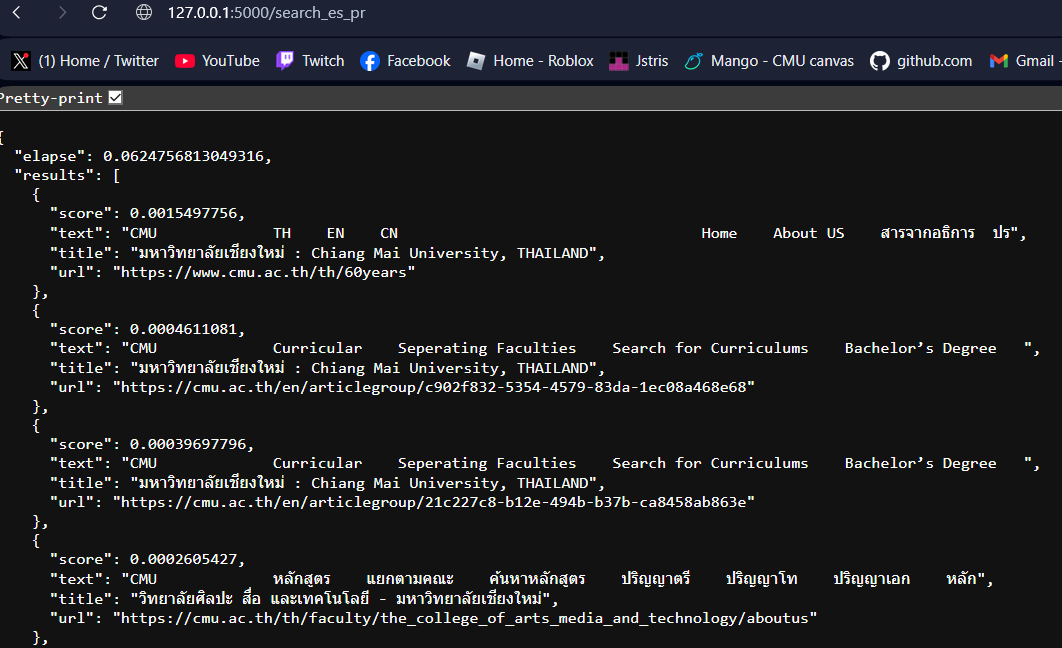

Result of `manual search pr`

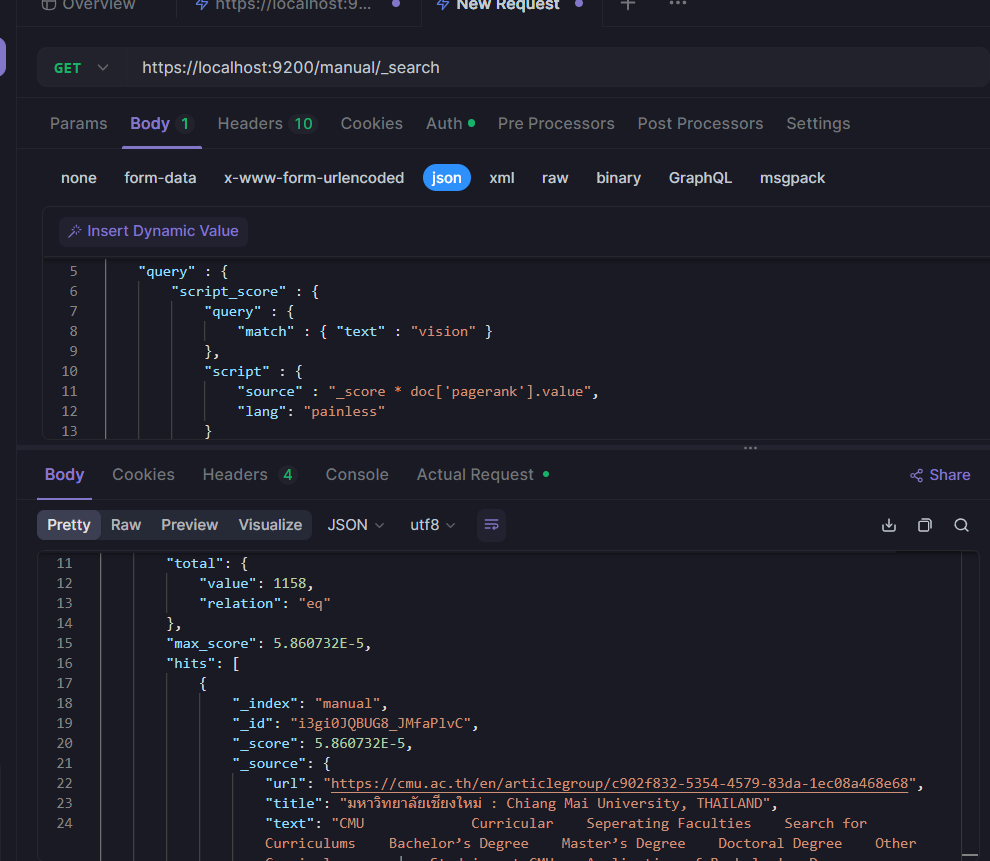